Author : Dipak Sah

Task : Melanoma Detection Assignment  


## Problem statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

* Actinic keratosis
* Basal cell carcinoma
* Dermatofibroma
* Melanoma
* Nevus
* Pigmented benign keratosis
* Seborrheic keratosis
* Squamous cell carcinoma
* Vascular lesion

Build a multiclass classification model using a custom convolutional neural network in TensorFlow.

### Importing all the important libraries neeed for this assignment

In [1]:
#Importing all the important libraries
import pathlib
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import experimental
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Using input file from google drive
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


# 1. Data Reading/Data Understanding

1.1 Defined the path for both train and test images from dataset.

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test  = pathlib.Path('/content/gdrive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
# Checking the available image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Total Train Image count is ', image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Total Test Image count is ',image_count_test)

Total Train Image count is  2239
Total Test Image count is  118


# 2. Dataset creation

* Created train & validation dataset from the train directory with a batch size of 32 .

* Resized images to 180*180.(10%)

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

## 2.1  Created train & validation dataset from the train directory with a batch size of 32 .

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width  = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Creating train dataset
## Using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Creating validation dataset
## Using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Listing out all the classes of skin cancer and storing them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# 3. Dataset visualisation

* Created a code to visualize one instance of all the nine classes present in the dataset

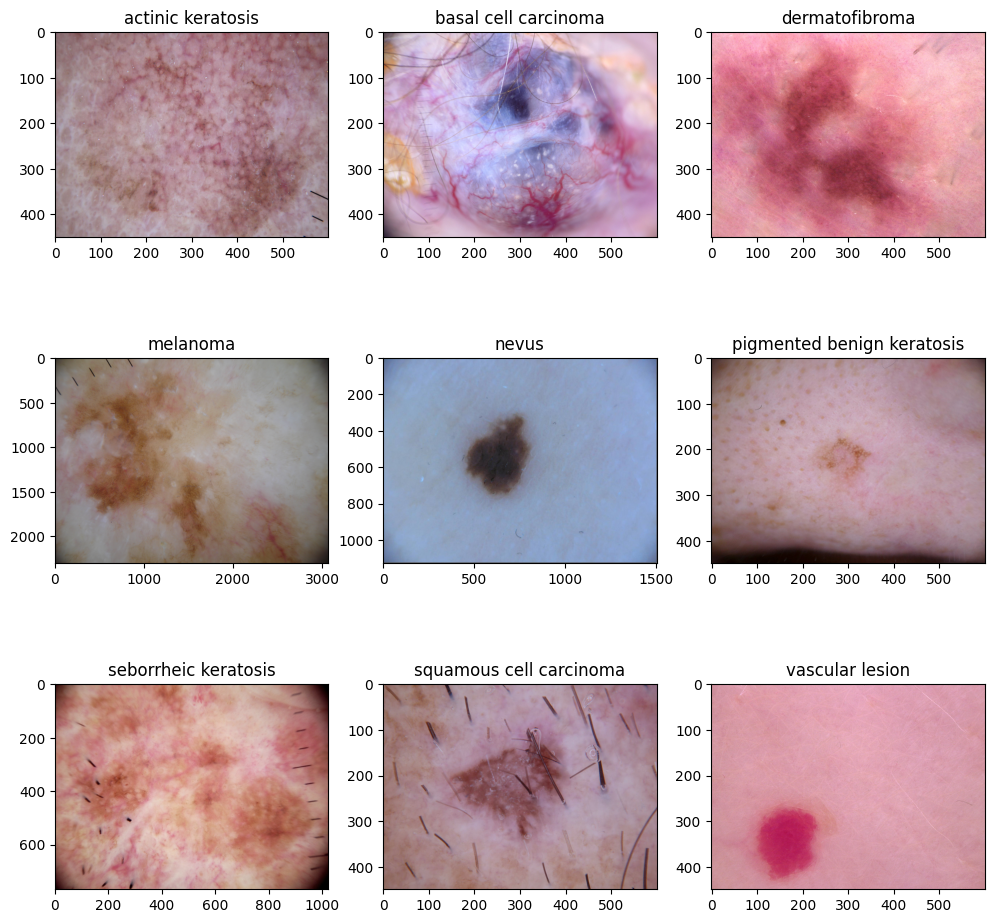

In [9]:
### Visualization from training dataset

plt.figure(figsize=(12,12))
for i in range(len(class_names)):
  plt.subplot(3,3,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 4. Model Building & training on train data

* Creating a CNN model, which can accurately detect 9 classes present in the dataset.

* Defining appropriate optimiser and loss function for model training.

* Training the model for ~20 epochs.

* Explaining the findings after the model fit with evidence if the model overfits or underfits.

# 4.1 Creating a CNN model, which can accurately detect 9 classes present in the dataset.

### Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
# CNN Model on train data
model = Sequential()

# scaling the pixel values from 0-255 to 0-1
model.add(experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# 1st Block
# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# 2nd Block
# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Classification layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(9, activation='softmax'))


## 4.2 Defining appropriate optimiser and loss function for model training.

### Compile the model


In [12]:
### Using optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 259200)            0

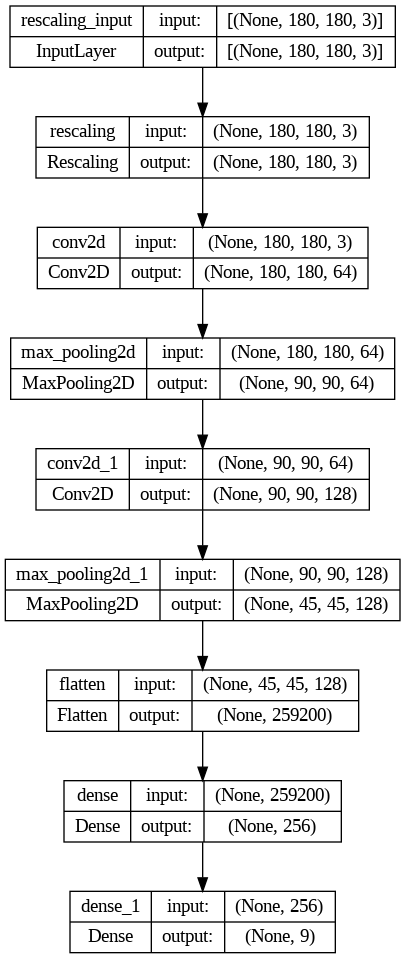

In [14]:
# Visualizing the summary in a flow diagram
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## 4.3 Training the model for ~20 epochs.

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 625s 3s/step - loss: 3.7370 - accuracy: 0.2913 - val_loss: 1.7533 - val_accuracy: 0.3154
Epoch 2/20
56/56 [==============================] - 4s 71ms/step - loss: 1.5831 - accuracy: 0.4481 - val_loss: 1.4724 - val_accuracy: 0.5011
Epoch 3/20
56/56 [==============================] - 4s 72ms/step - loss: 1.3990 - accuracy: 0.5240 - val_loss: 1.4264 - val_accuracy: 0.5190
Epoch 4/20
56/56 [==============================] - 4s 72ms/step - loss: 1.2950 - accuracy: 0.5458 - val_loss: 1.3581 - val_accuracy: 0.5459
Epoch 5/20
56/56 [==============================] - 4s 71ms/step - loss: 1.1699 - accuracy: 0.5943 - val_loss: 1.4866 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 4s 73ms/step - loss: 1.0959 - accuracy: 0.6194 - val_loss: 1.4503 - val_accuracy: 0.4944
Epoch 7/20
56/56 [==============================] - 4s 71ms/step - loss: 0.9816 - accuracy: 0.6769 - val_loss: 1.6157 - val_accuracy: 0.5123
Epoch 8/20
56

### Visualizing training results

In [16]:
# defining function to visualize the metrics
def plot_metrics():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    return()

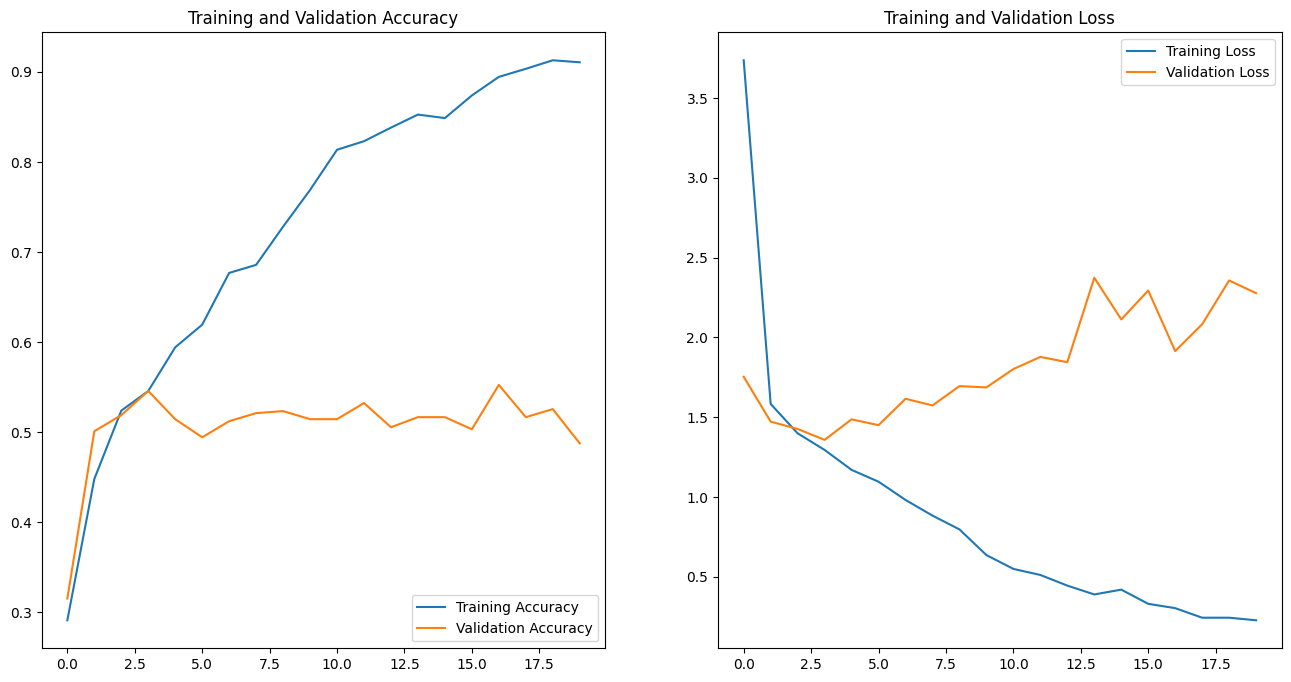

()

In [17]:
# Visualize the metrics
plot_metrics()

In [18]:
# Printing accuracy and loss
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_val, accuracy_val = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_val)
print("Loss: ",loss)
print("Validation Loss", loss_val)

14/14 [==============================] - 0s 18ms/step - loss: 2.2775 - accuracy: 0.4877
Accuracy:  0.91796875
Validation Accuracy:  0.48769575357437134
Loss:  0.21164347231388092
Validation Loss 2.277474880218506


## 4.4 Explaining the findings after the model fit with evidence if the model overfits or underfits.


### Findings from Above Model

 1. The training accuracy increases linearly over time, where as the validation accuracy settles at around 50% accuracy .
 2. The training loss dereases but on the other side the validation loss increases.
 3. The plots show that difference between training accuracy and validation accuracy start widening after 5th epoch.
 4. The difference in accuracy between training and validation accuracy is very significant which is a sign of overfitting.




# 5. Model Building & training on train data using dropout

* Creating a CNN model using dropout, which can accurately detect 9 classes present in the dataset.

* Defining appropriate optimiser and loss function for model training.

* Training the model for ~20 epochs.

* Explaining the findings after the model fit with evidence if the model overfits or underfits.


## 5.1 Creating a CNN model using dropout, which can accurately detect 9 classes present in the dataset.

In [19]:
# CNN Model on train data using dropout
model = Sequential()

# scaling the pixel values from 0-255 to 0-1
model.add(experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# 1st Block
# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

# 2nd Block
# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

# Classification layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(9, activation='softmax'))

## 5.2 Defining appropriate optimiser and loss function for model training.

### Compiling the model

In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 90, 90, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

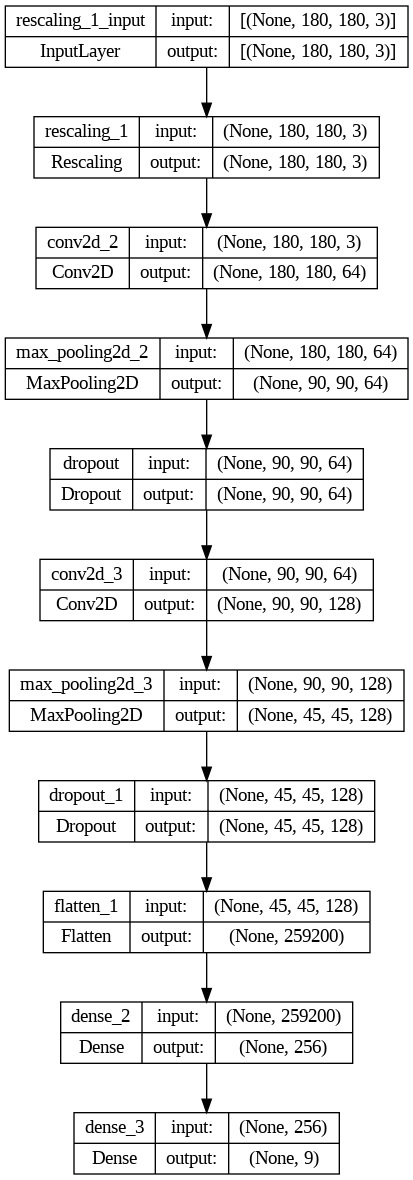

In [22]:
# Visualizing the summary in a flow diagram
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## 5.3 Training the model for ~20 epochs.

In [23]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 9s 119ms/step - loss: 4.9669 - accuracy: 0.1802 - val_loss: 2.1753 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 7s 117ms/step - loss: 2.1011 - accuracy: 0.2132 - val_loss: 2.1036 - val_accuracy: 0.2013
Epoch 3/20
56/56 [==============================] - 7s 117ms/step - loss: 1.9522 - accuracy: 0.2628 - val_loss: 1.9402 - val_accuracy: 0.3221
Epoch 4/20
56/56 [==============================] - 7s 117ms/step - loss: 1.7399 - accuracy: 0.3772 - val_loss: 1.8237 - val_accuracy: 0.3266
Epoch 5/20
56/56 [==============================] - 7s 118ms/step - loss: 1.5158 - accuracy: 0.4576 - val_loss: 1.6656 - val_accuracy: 0.4139
Epoch 6/20
56/56 [==============================] - 7s 117ms/step - loss: 1.4537 - accuracy: 0.4844 - val_loss: 1.6723 - val_accuracy: 0.4765
Epoch 7/20
56/56 [==============================] - 7s 117ms/step - loss: 1.3573 - accuracy: 0.5201 - val_loss: 1.4685 - val_accuracy: 0.5056
Epoch 

### Visualizing the results

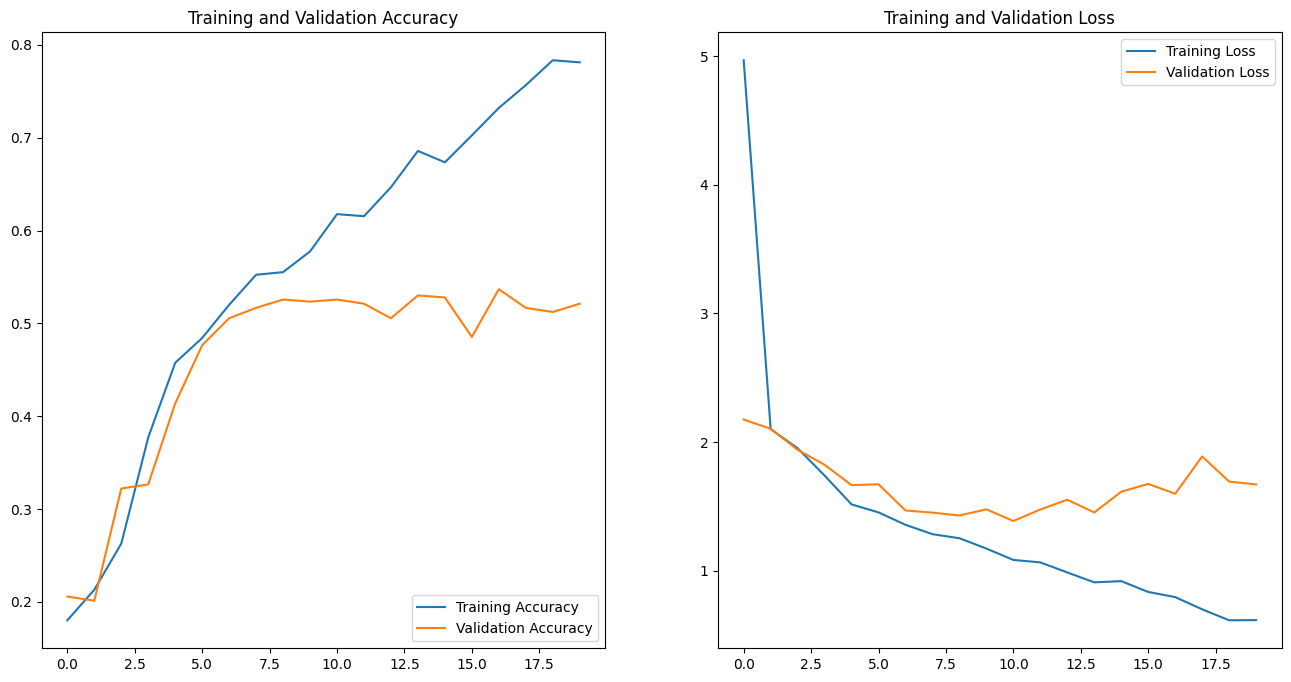

()

In [24]:
plot_metrics()

In [25]:
# Printing accuracy and loss
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_val, accuracy_val = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_val)
print("Loss: ",loss)
print("Validation Loss", loss_val)

14/14 [==============================] - 0s 18ms/step - loss: 1.6709 - accuracy: 0.5213
Accuracy:  0.8404017686843872
Validation Accuracy:  0.5212528109550476
Loss:  0.5306851267814636
Validation Loss 1.6708860397338867


## 5.4 Explaining the findings after the model fit with evidence if the model overfits or underfits.


### Findings from above Model

 1. The training accuracy increases linearly over time, where as the validation accuracy again settles at 51-52% accuracy .
 2. The training loss dereases but on the other side the validation loss increases.
 3. The plots show that difference between training accuracy and validation accuracy start widening after 8th epoch.
 4. Both training accuracy and validation accuracy has declined a little. But, the difference in accuracy between training and validation accuracy still very significant which is a sign of overfitting. Training accuracy is high  and validation accuracy is still low at 52%


# 6. Data augmentation

* Chosing an appropriate data augmentation strategy to resolve underfitting/overfitting

In [26]:
data_augmentation = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

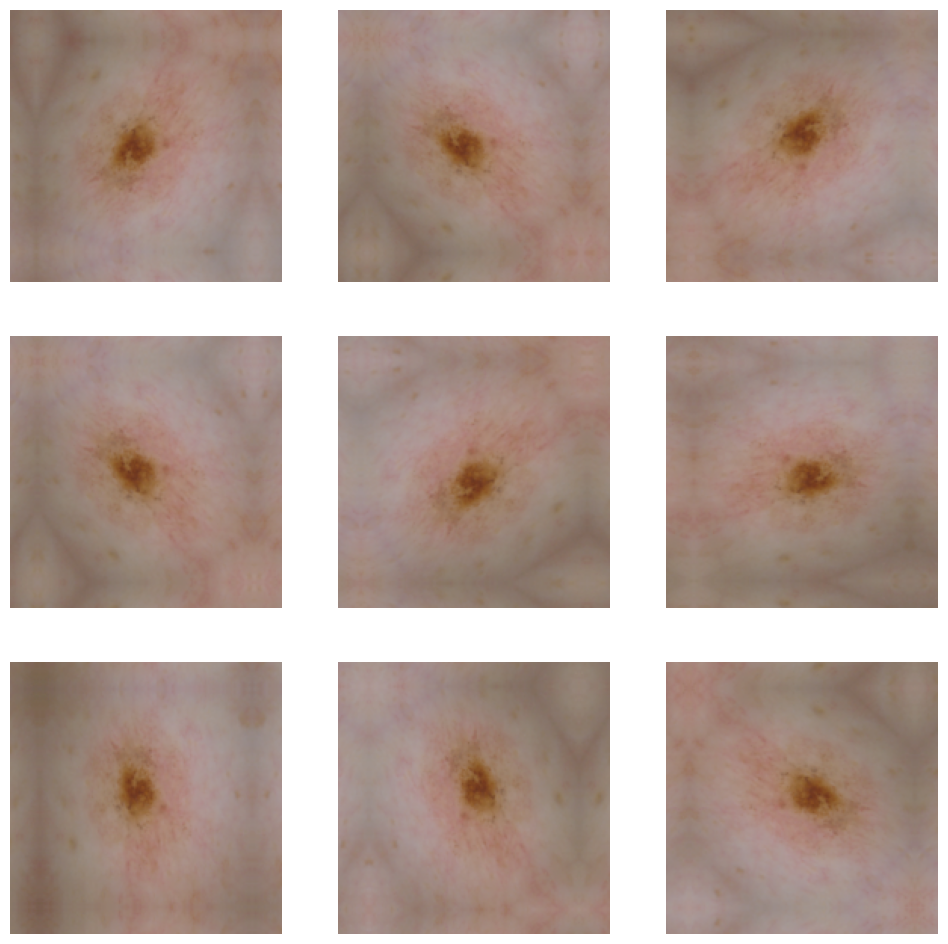

In [27]:
# visualizing how augmentation strategy is working for one instance of training image.

plt.figure(figsize=(12, 12))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# 7. Model Building & training on Augumented Data:
* Creating a CNN model, which can accurately detect 9 classes present in the dataset.
* Defining appropriate optimiser and loss function for model training.
* Training the model for ~20 epochs.
* Explaining the findings after the model fit with evidence if the earlier issue is resolved or not.

## 7.1 Creating a CNN model, which can accurately detect 9 classes present in the dataset.

In [28]:
# CNN Model on Augumented Data

# scaling the pixel values from 0-255 to 0-1
# Using data augmentation
model = Sequential([data_augmentation, experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))])

# 1st Block
# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

# 2nd Block
# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

#Classification block
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(9, activation='softmax'))

## 7.2 Defining appropriate optimiser and loss function for model training.

In [29]:
# Compiling the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Displaying the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 90, 90, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 128)       73856     
                                                      

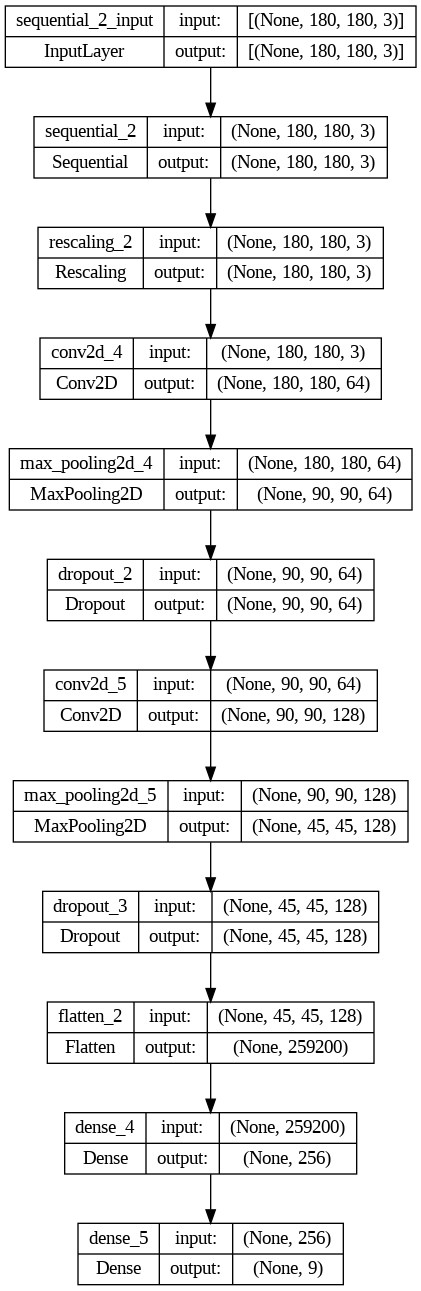

In [30]:
# Visualizing the summary in the work flow
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## 7.3 Training the model for ~20 epochs.

In [31]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 9s 119ms/step - loss: 5.1456 - accuracy: 0.1869 - val_loss: 2.1272 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 7s 119ms/step - loss: 1.9263 - accuracy: 0.2941 - val_loss: 1.9585 - val_accuracy: 0.2975
Epoch 3/20
56/56 [==============================] - 7s 121ms/step - loss: 1.6782 - accuracy: 0.4007 - val_loss: 1.7394 - val_accuracy: 0.4004
Epoch 4/20
56/56 [==============================] - 7s 120ms/step - loss: 1.6041 - accuracy: 0.4302 - val_loss: 1.7224 - val_accuracy: 0.3982
Epoch 5/20
56/56 [==============================] - 7s 119ms/step - loss: 1.5830 - accuracy: 0.4487 - val_loss: 1.5932 - val_accuracy: 0.4407
Epoch 6/20
56/56 [==============================] - 7s 120ms/step - loss: 1.4422 - accuracy: 0.5056 - val_loss: 1.5562 - val_accuracy: 0.4430
Epoch 7/20
56/56 [==============================] - 7s 119ms/step - loss: 1.4846 - accuracy: 0.4838 - val_loss: 1.5371 - val_accuracy: 0.4519
Epoch 

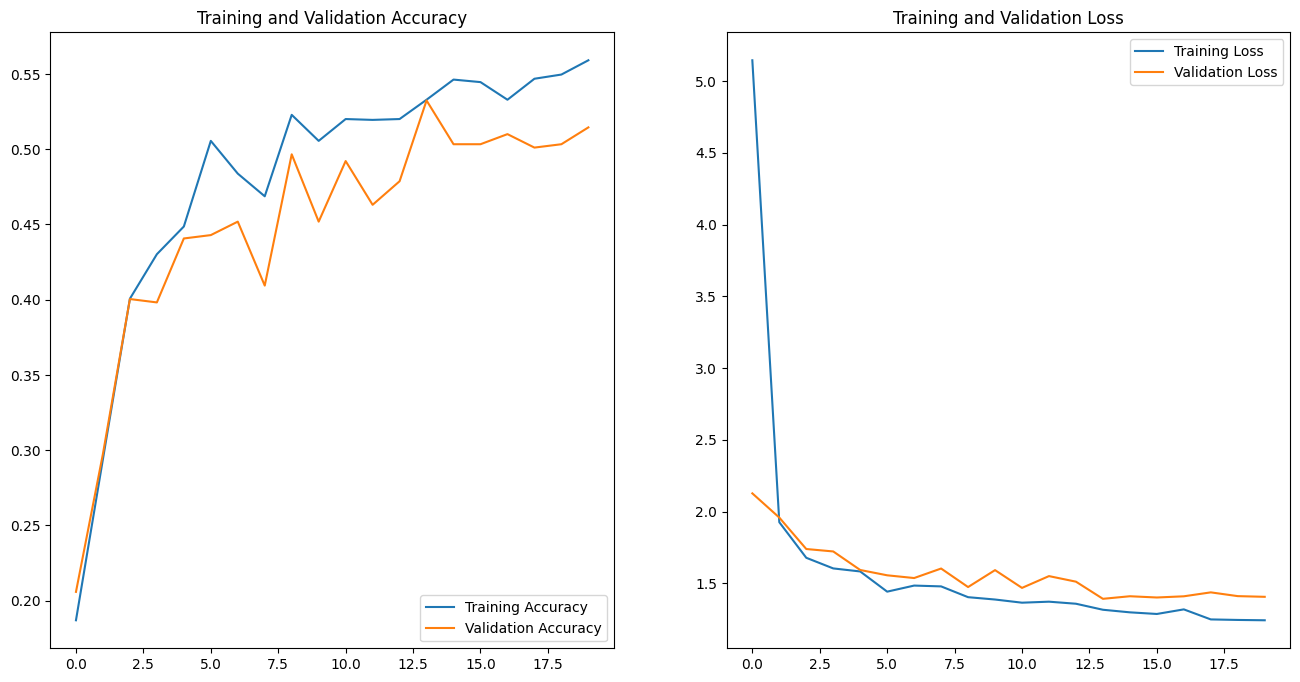

()

In [32]:
# plotting the accuracy and loss
plot_metrics()

In [33]:
# Printing accuracy and loss
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_val, accuracy_val = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_val)
print("Loss: ",loss)
print("Validation Loss", loss_val)

14/14 [==============================] - 0s 18ms/step - loss: 1.4063 - accuracy: 0.5145
Accuracy:  0.5452008843421936
Validation Accuracy:  0.5145413875579834
Loss:  1.290511131286621
Validation Loss 1.4062522649765015


## 7.4 Explaining the findings after the model fit with evidence if the model overfits or underfits.

### Findings from above Model

 1. The plot shows that overfitting is handled after data augmentation.
 2. But accuracy has declined to around **54%**


# 8. Class distribution

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [34]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df_imbalance = class_distribution_count(data_dir_train)
df_imbalance


,Class,No. of Image
0,vascular lesion,139
1,seborrheic keratosis,77
2,pigmented benign keratosis,462
3,squamous cell carcinoma,181
4,basal cell carcinoma,376
5,actinic keratosis,114
6,nevus,357
7,melanoma,438
8,dermatofibroma,95


<Axes: xlabel='No. of Image', ylabel='Class'>

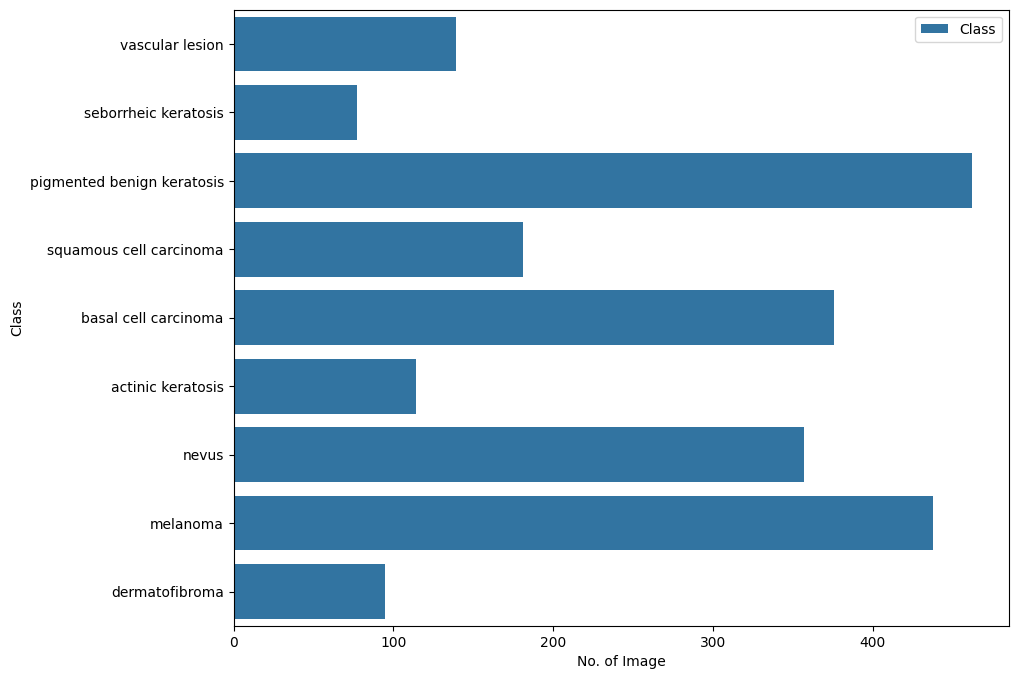

In [35]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df_imbalance,
            label="Class")

#### Findings from class distribution count stats:
#### - Which class has the least number of samples?
**seborrheic keratosis**

#### - Which classes dominate the data in terms proportionate number of samples?
**melanoma** and **pigmented benign keratosis** have highest number of samples


# 9. Handling class imbalances

####  Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [36]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [37]:
path_to_training_dataset= '/content/gdrive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x796C806A6F50>: 100%|██████████| 500/500 [00:22<00:00, 22.08 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x796C8199BB20>: 100%|██████████| 500/500 [00:25<00:00, 19.83 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x796C8196EC50>: 100%|██████████| 500/500 [00:19<00:00, 26.25 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x796C806550C0>: 100%|██████████| 500/500 [01:31<00:00,  5.48 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x796CC85329B0>: 100%|██████████| 500/500 [01:19<00:00,  6.26 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x796DD6853880>: 100%|██████████| 500/500 [00:20<00:00, 24.70 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x796D30441CF0>: 100%|██████████| 500/500 [00:38<00:00, 12.89 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x796CC8473CA0>: 100%|██████████| 500/500 [00:20<00:00, 23.93 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x796D5388A080>: 100%|██████████| 500/500 [00:18<00:00, 26.49 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025452.jpg_024890d4-0fd5-4149-825c-dddf36b7baf8.jpg',
 '/content/gdrive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031759.jpg_5d245c24-da4c-4ada-a598-19ed8987d8cb.jpg',
 '/content/gdrive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025924.jpg_e4149358-8834-4067-a8be-a4e0897ef23a.jpg',
 '/content/gdrive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029514.jpg_60b30df1-3160-4676-8b37-0ef0b765cbdf.jp

In [40]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [41]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [42]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [43]:
df2['Label'].value_counts()

Label
vascular lesion               500
seborrheic keratosis          500
pigmented benign keratosis    500
squamous cell carcinoma       500
basal cell carcinoma          500
actinic keratosis             500
nevus                         500
melanoma                      500
dermatofibroma                500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [44]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset after Augmentation

In [45]:
data_dir_train= '/content/gdrive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset after Augmentation

In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


# 10. Model Building & training on Augumented Data:
* Creating a CNN model on class imbalance rectified augmented data, which can accurately detect 9 classes present in the dataset.
* Defining appropriate optimiser and loss function for model training.
* Training the model for ~30 epochs.
* Explaining the findings after the model fit with evidence if the earlier issue is resolved or not.

## 10.1 Creating a CNN model on class imbalance rectified augmented data, which can accurately detect 9 classes present in the dataset.

In [52]:
# CNN Model on lass imbalance rectified augmented data, we are using batch normalization

model = Sequential()

# scaling the pixel values from 0-255 to 0-1
model.add(experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# 1st Block
# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

# 2nd Block
# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

# 3rd Block
# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

# Classification block
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(9, activation='softmax'))


## 10.2 Defining appropriate optimiser and loss function for model training.

In [53]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Displaying the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 batch_normalization_3 (Bat  (None, 180, 180, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 90, 90, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 64)       

##  10.3  Training the model for ~30 epochs.

In [54]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 46s 254ms/step - loss: 5.7467 - accuracy: 0.3055 - val_loss: 8.1261 - val_accuracy: 0.1403
Epoch 2/30
169/169 [==============================] - 45s 257ms/step - loss: 1.6410 - accuracy: 0.4186 - val_loss: 8.8485 - val_accuracy: 0.1849
Epoch 3/30
169/169 [==============================] - 46s 266ms/step - loss: 1.4831 - accuracy: 0.4659 - val_loss: 5.7096 - val_accuracy: 0.2487
Epoch 4/30
169/169 [==============================] - 45s 256ms/step - loss: 1.3637 - accuracy: 0.4985 - val_loss: 2.5755 - val_accuracy: 0.4061
Epoch 5/30
169/169 [==============================] - 44s 253ms/step - loss: 1.2289 - accuracy: 0.5376 - val_loss: 2.3169 - val_accuracy: 0.4091
Epoch 6/30
169/169 [==============================] - 49s 280ms/step - loss: 1.0896 - accuracy: 0.5933 - val_loss: 3.1856 - val_accuracy: 0.4670
Epoch 7/30
169/169 [==============================] - 45s 258ms/step - loss: 1.0197 - accuracy: 0.6198 - val_loss: 2.9508 - val_ac

####   Visualize the model results

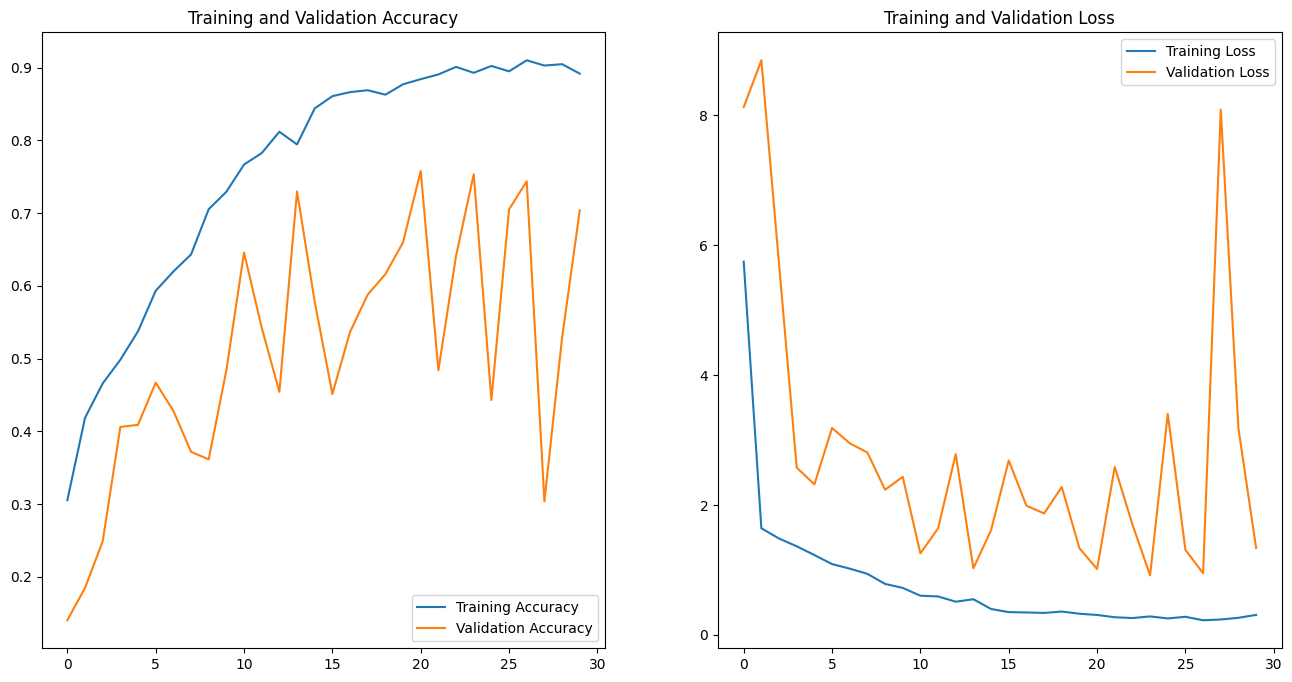

()

In [55]:
# plotting the accuracy and loss
plot_metrics()

In [56]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_val, accuracy_val = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_val)
print("Loss: ",loss)
print("Validation Loss", loss_val)

43/43 [==============================] - 7s 134ms/step - loss: 1.3375 - accuracy: 0.7038
Accuracy:  0.8312314748764038
Validation Accuracy:  0.7037861943244934
Loss:  0.5254261493682861
Validation Loss 1.3375215530395508


## 10.4 Explaining the findings after the model fit with evidence if the earlier issue is resolved or not.


### Findings from above Model

 1. After balacing the dataset, we do not see any sign of overfitting or underfitting.
 2. The training and validation accuracy has improved.



# 11. Conclusion

- Without the use of dropout layer, the model tend to overfit. There is huge difference betwee the training accuracy and validation accuracy.
- With the inclusion of dropout layer, the problem of overfitting is not solved but overall accuracy got declined by 0.05.
- While checking the distribution of classes in training dataset, it is noticed that some classes have very low volume and some has very high volume.
- Augmentor was used to generate 500 images of each class so that some balance is achieved.
- Final model is created by doing following changes:
    - Batch normalization is added to the conv2D layers.
    - one more Conv2 layer block is added to capture more details.
- Final model gives very good accuracy and does not show any sign of overfitting or underfitting. Training and validation losses are also small.

Quick Summary of all Models:
----------------------------

- Conclusion : Model with input train data without dropout
        1.  Accuracy:  0.91796875 and Validation Accuracy:  0.48769575357437134
        2.  The difference in accuracy between training and validation accuracy is very significant which is a sign of overfitting.

- Conclusion : Model with input train data with dropout
        1.  Accuracy:  0.8404017686843872 and Validation Accuracy:  0.5212528109550476
        2.  Both training accuracy and validation accuracy has declined a little. But, the difference in accuracy between training and validation accuracy still very significant which is a sign of overfitting.

- Conclusion : Model with data augmentation applied in keras sequential
        1.  Accuracy:  0.5452008843421936 and Validation Accuracy:  0.5145413875579834
        2.  Overfitting is handled but accuracy delined drastically below 54%.

- Conclusion : Model with class imbalance rectified with Augmentor Library, also applied batch normalization
        1.  Accuracy:  0.8312314748764038 and Validation Accuracy:  0.7037861943244934
        2.  After balacing the dataset, we do not see any sign of overfitting or underfitting.
